In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

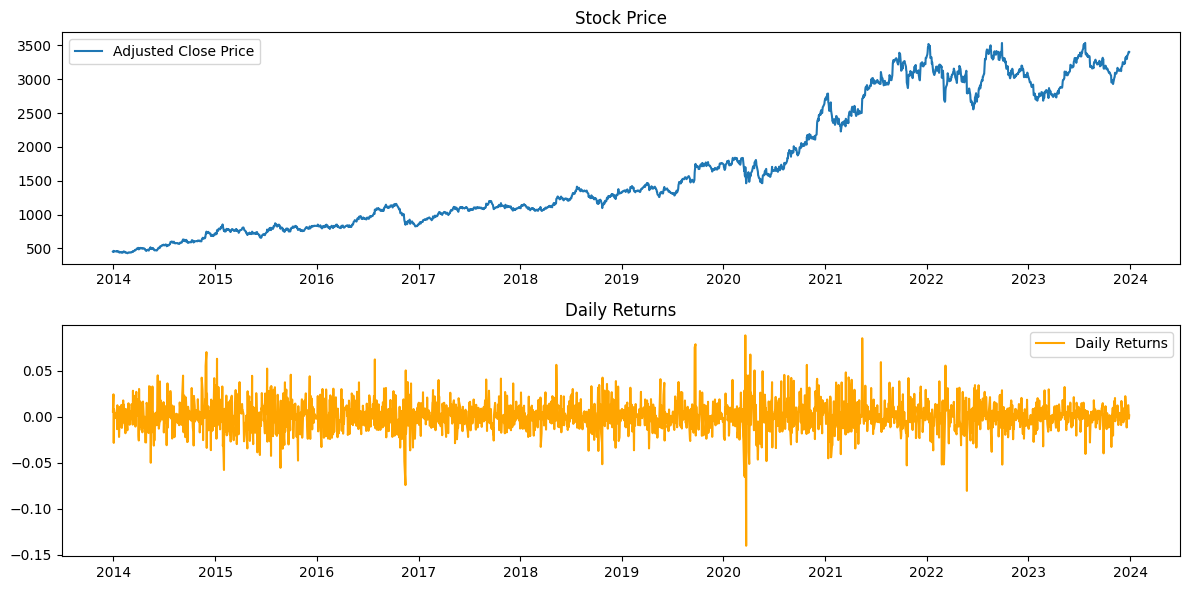

In [55]:

# Download historical stock data
filepath = '../combinesCSVs/ASIANPAINT_combined.csv'
data = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
data['Returns'] = data['Close'].pct_change()  # Daily returns
data = data[data.index >= (data.index.max() - pd.DateOffset(years=10))]  # Filter for the last 5 years
# Drop NaN values
data.dropna(inplace=True)

# Plot the stock price and returns
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.title('Stock Price')
plt.legend()

plt.subplot(2,1,2)
plt.plot(data['Returns'], label='Daily Returns', color='orange')
plt.title('Daily Returns')
plt.legend()

plt.tight_layout()
plt.show()

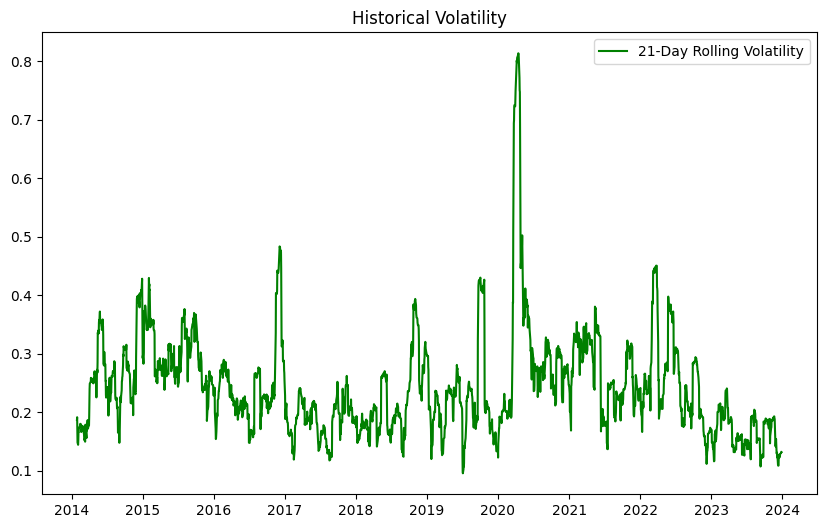

In [56]:
# Calculate historical volatility
window = 21  # 21 trading days
data['Volatility'] = data['Returns'].rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

# Plot historical volatility
plt.figure(figsize=(10,6))
plt.plot(data['Volatility'], label='21-Day Rolling Volatility', color='green')
plt.title('Historical Volatility')
plt.legend()
plt.show()

In [57]:
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Feature: 21-day rolling mean (Moving Average)
data['MA_21'] = data['Adj Close'].rolling(window=21).mean()

# Feature: RSI
rsi = RSIIndicator(data['Adj Close'], window=14)
data['RSI'] = rsi.rsi()

# Feature: MACD
macd = MACD(data['Adj Close'])
data['MACD'] = macd.macd_diff()

# Drop NaN values
data.dropna(inplace=True)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
# Create target variable
data['Future_Volatility'] = data['Volatility'].shift(-21)  # Forecast 21 days ahead

# Drop NaN values
data.dropna(inplace=True)

# Features and target
X = data[['MA_21', 'RSI', 'MACD', 'Volatility']]
y = data['Future_Volatility']

# Split data into training and testing sets
X_train = X[data.index < '2023-01-01']  # Use data before 2023 for training
y_train = y[data.index < '2023-01-01']  # Use data before 2023 for training
X_test = X[data.index >= '2023-01-01']  # Use data from 2023 for testing
y_test = y[data.index >= '2023-01-01']  # Use data from 2023 for testing

# Train Random Forest model
model = RandomForestRegressor(n_estimators=250, random_state=42)  # Corrected parameter name
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.05378517203851199


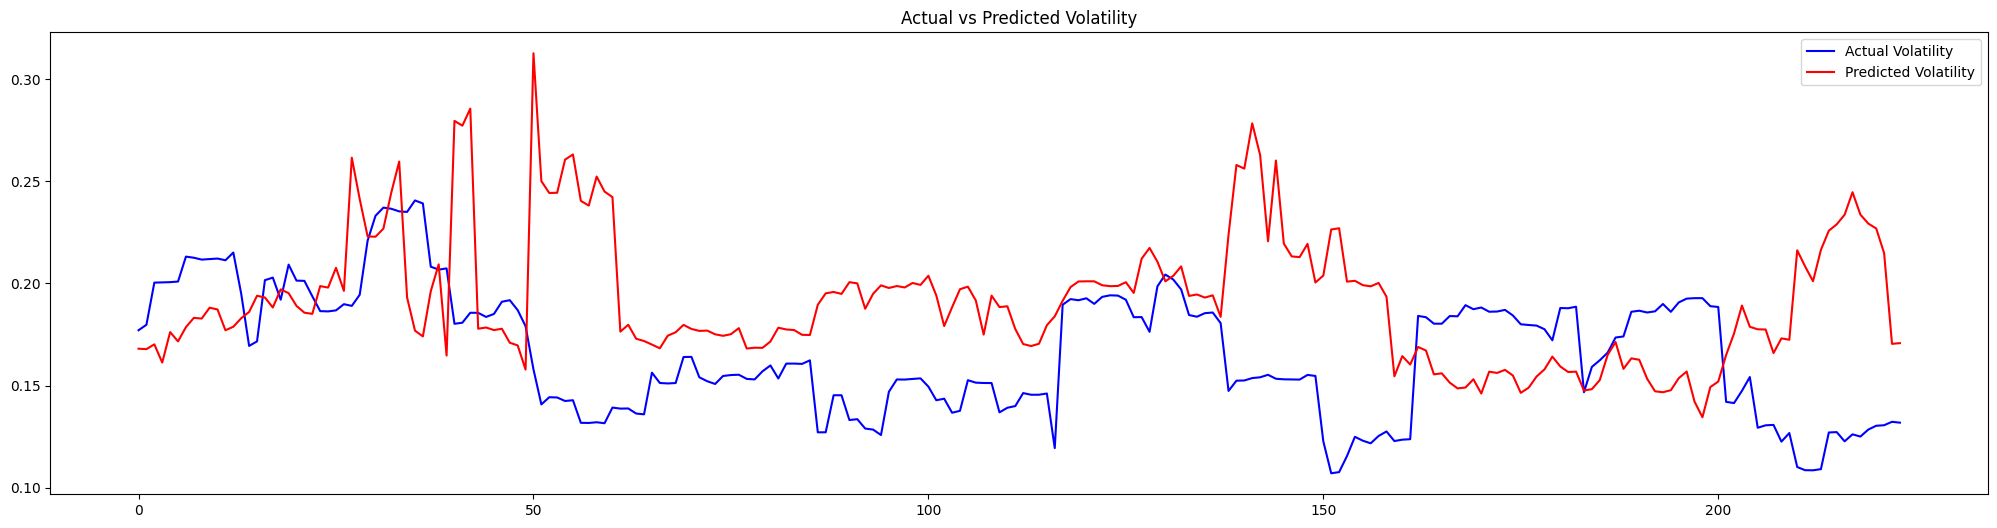

In [59]:
plt.figure(figsize=(25,6))
plt.plot(y_test.values, label='Actual Volatility', color='blue')
plt.plot(y_pred, label='Predicted Volatility', color='red')
plt.title('Actual vs Predicted Volatility')
plt.legend()
plt.show()

In [60]:
# Example: Position sizing based on forecasted volatility
initial_capital = 100000  # $100,000
volatility_forecast = model.predict(X_test[-1:])[0]  # Forecast next volatility

# Risk per trade = 1% of capital
risk_per_trade = 0.10 * initial_capital

# Position size = risk per trade / forecasted volatility
position_size = risk_per_trade / volatility_forecast

print(f'Recommended Position Size: {position_size}')

Recommended Position Size: 58542.87345053237
